In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import Voronoi, voronoi_plot_2d
from ipywidgets import Image
from IPython import display
%matplotlib widget

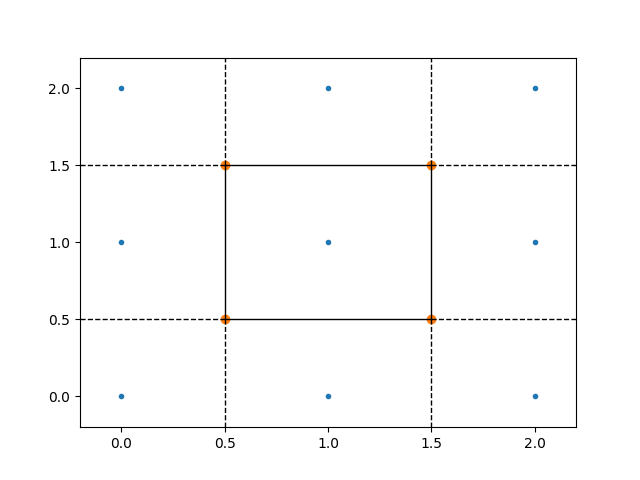

In [2]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.show()

In [3]:
w1data = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
w1data.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


In [4]:
def collect_game_info(weekdf, playId, saved=False):
    
    #slice df to single play
    playdf = weekdf.loc[weekdf["playId"] == playId]
    #reorder playdf so that they are in the right frame order
    playdf = playdf.sort_values(by = "frameId")
    if saved:
        playdf.to_csv(f'Play{playId}Frames.csv')
    return playdf

In [5]:
class Animation:
    def __init__(self, weekdf, playId):
        # Get the play info
        self.play_df = collect_game_info(weekdf, playId).dropna()
        # convert frameId to integer values
        self.play_df['frameId'] = self.play_df['frameId'].astype('int')
        # Reindex to players and frames (these are what we're plotting over)
        self.player_df = self.play_df.set_index(['jerseyNumber', 'frameId'])

        self.num_frames = len(self.play_df['frameId'].unique())
        self.num_players = len(self.play_df['jerseyNumber'].unique())
        self.teams = self.player_df['team'].unique()

        # Get team colours (so far this is just random, eventually should be attacking team is always same colour)
        self.team_cols = {self.teams[0]:'red', self.teams[1]:'blue'}

        # Plotting range with some padding
        self.xrange = (self.player_df['x'].min()-5, self.player_df['x'].max()+5)
        self.yrange = (self.player_df['y'].min()-5, self.player_df['y'].max()+5)

        self.fig = plt.figure()
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)


        # Trajectory initialisation (for animation)
        self.trajs = []
        for index in range(self.num_players):
            l_object = self.axes.plot([],[])
            self.trajs.append(l_object[0])

    def init_frame(self):
        for traj in self.trajs:
            traj.set_data([],[])
        return self.trajs

    def frame(self, i):
        print(f'Frame {i+1}/{self.num_frames}\r', end="")
        # get the trajectories for each jerseyNumber from frameId 0->i
        self.axes.clear()
        plt.axis('off')
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)

        # Find the trajectories (xs and ys before frame i)
        player_trajs = self.player_df[self.player_df.index.get_level_values('frameId').isin(range(1, i+1))] # bruh

        #dictionary to reference which index of current_pos to fill
        team_dict = {self.teams[0]: 0, self.teams[1]: 1}

        # Plot each players trajectory
        current_pos = [], []
        for loop_index, traj_index in enumerate(player_trajs.index):
            jersey_number, frame_number = traj_index
            pos_df = player_trajs.loc[jersey_number][['x', 'y', 'team']]
            team = pos_df.loc[i, ['team']].values[0]
            #fill current_pos with latest positions
            if frame_number == i:
                current_pos[team_dict[team]].append(pos_df.loc[i, ['x', 'y']].to_numpy())
            #get the colour of the player based off their team (again this will change later to attacking/defending rather than team)
            colour = self.team_cols[pos_df['team'][1]]
            self.axes.plot(pos_df['x'], pos_df['y'], c=colour)

        current_pos = np.stack((np.vstack(current_pos[0]), np.vstack(current_pos[1])), axis=0)
        
        vor1 = Voronoi(current_pos[0])
        vor2 = Voronoi(current_pos[1])
        voronoi_plot_2d(vor1)
        plt.show()
        #self.axes.triplot(current_pos[0][:, 0], current_pos[0][:, 1], delaunay_triangulation1.simplices, c=self.team_cols[self.teams[0]])
        #self.axes.triplot(current_pos[1][:, 0], current_pos[1][:, 1], delaunay_triangulation2.simplices, c=self.team_cols[self.teams[1]])
        #self.axes.plot(current_pos[0][:, 0], current_pos[0][:, 1], 'o', c=self.team_cols[self.teams[0]])
        #self.axes.plot(current_pos[1][:, 0], current_pos[1][:, 1], 'o', c=self.team_cols[self.teams[1]])
            


    def animate(self):
        anim = animation.FuncAnimation(self.fig,func=self.frame, init_func=self.init_frame,
                      frames=self.num_frames, interval=1, blit=True)
        return anim
anim = Animation(w1data, 97).frame(40)

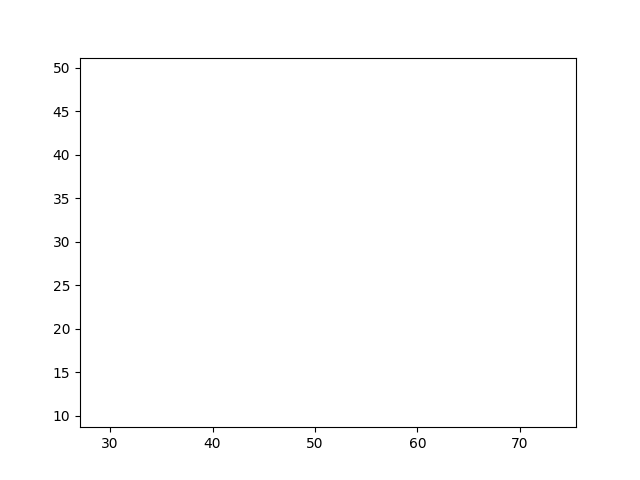

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7fb02ac9ef50>>
Traceback (most recent call last):
  File "/home/hiraeth/.local/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/home/hiraeth/.local/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 1226, in _on_timer
    ret = func(*args, **kwargs)
  File "/home/hiraeth/.local/lib/python3.10/site-packages/matplotlib/animation.py", line 1426, in _step
    still_going = super()._step(*args)
  File "/home/hiraeth/.local/lib/python3.10/site-packages/matplotlib/animation.py", line 1119, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/home/hiraeth/.local/lib/python3.10/site-packages/matplotlib/animation.py", line 1138, in _draw_next_frame
    self._draw_frame(framedata)
  File "/home/hiraeth/.local/lib/python3.10/site-packages/matplotlib/animation.py", line 1

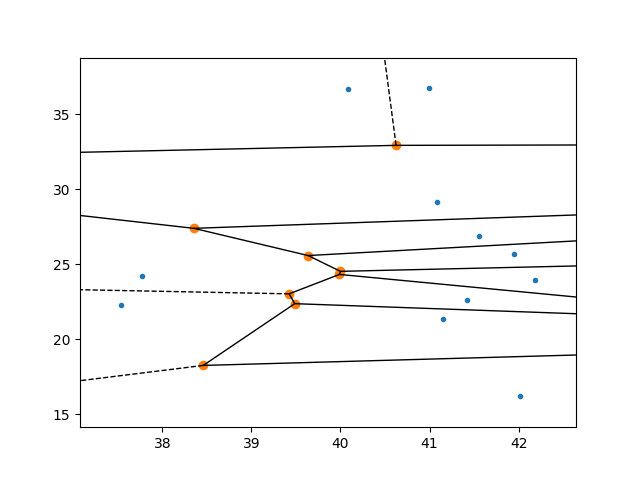

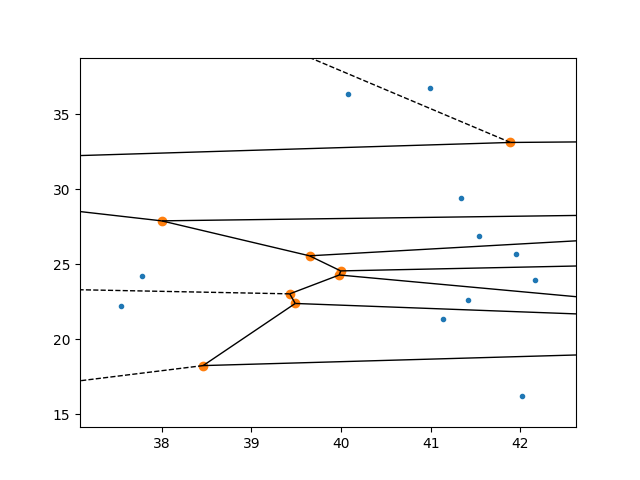

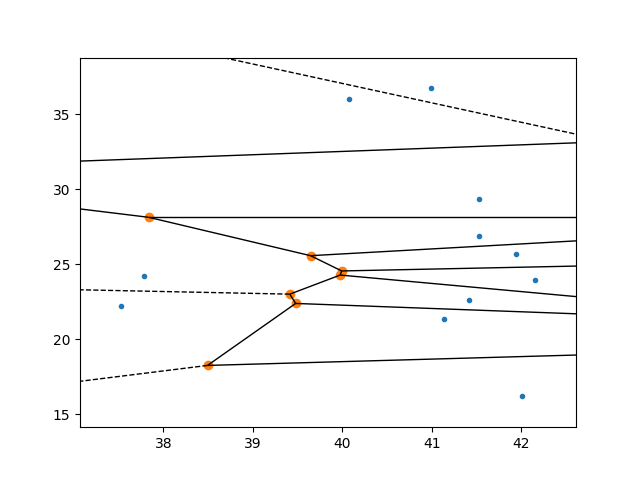

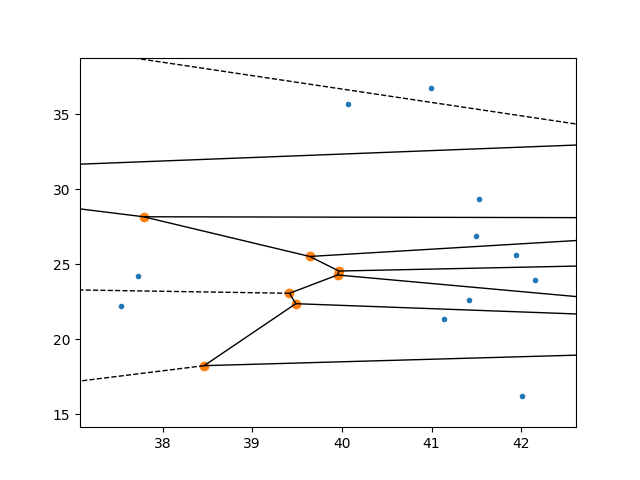

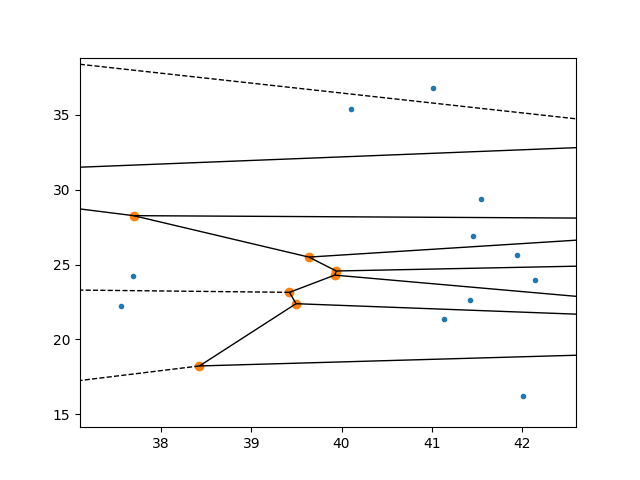

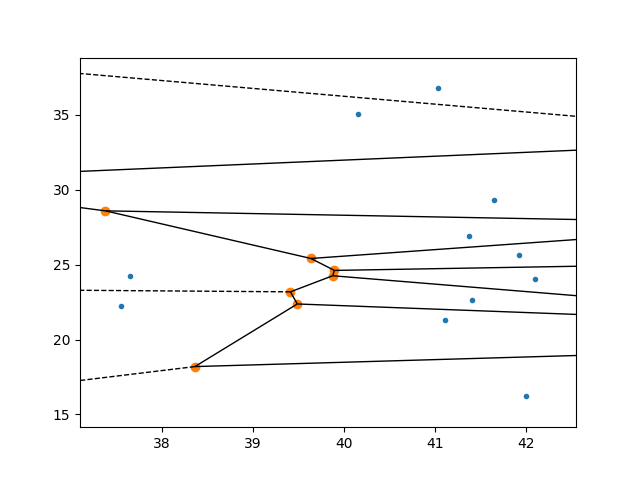

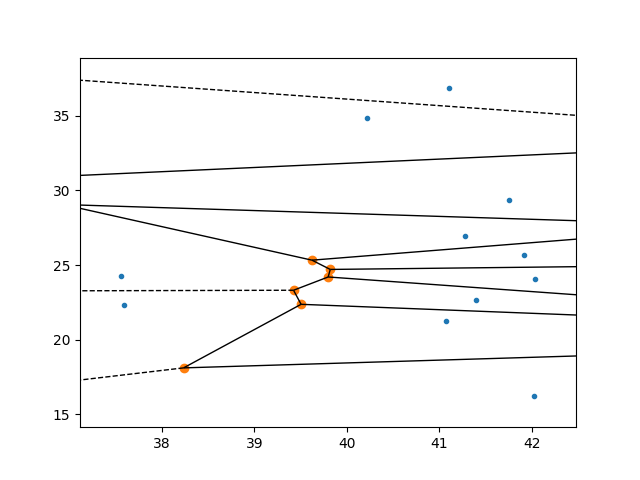

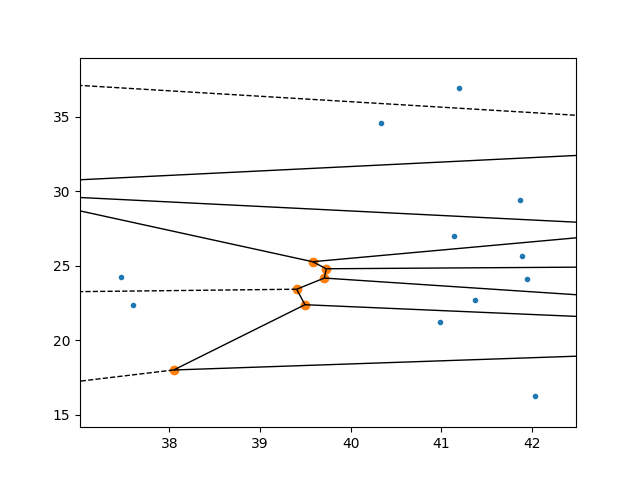

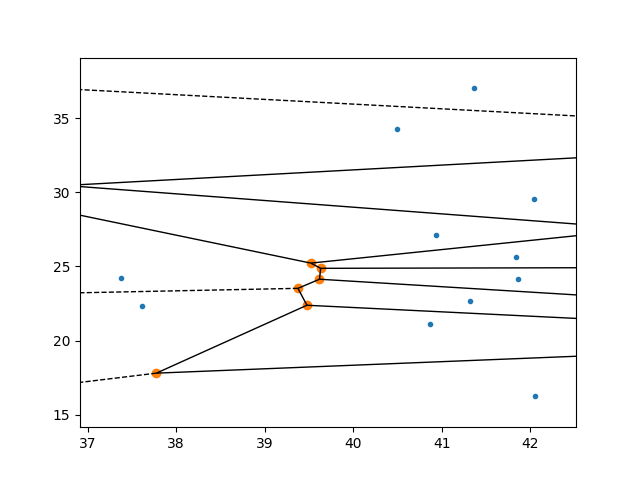

In [ ]:
play_num=97
anim = Animation(w1data, play_num).animate()
path = f'gifs/{play_num}.gif'
writergif = animation.PillowWriter(fps=2)
#anim.save(path, writer=writergif)

In [ ]:
#file = open(path , "rb")
#image = file.read()
#progress= Image(
#    value=image,
#    format='gif',
#    width=500,
#    height=500)
#display.display(progress)